In [34]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

(720, 1280, 3)


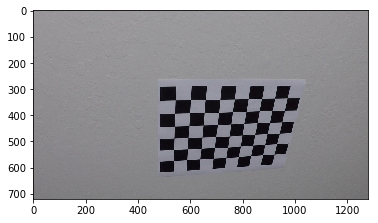

In [38]:
# Data exploration - One of the 20 images used for calibration
img = mpimg.imread("camera_cal/calibration10.jpg")
image_shape = img.shape
print(image_shape)
plt.imshow(img)

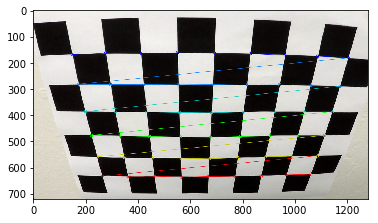

In [53]:
# For the calibration I used read the images in the way the Tutorial explained it
nx = 9
ny = 6

# Read in and make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")

#Arrays to store object points and image points from all the images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Prepare object points like (0,0,0), (1,0,0), (2,0,0) .../(7,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates

for fname in images:
    #read in each image
    img = mpimg.imread(fname)

    #Convert the image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Find the chessboard corners
    ret, corners = cv2. findChessboardCorners(gray, (nx,ny), None)

    #If corners are found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)